# Preparation 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/32933/

/content/gdrive/My Drive/32933


Download the (Skin Cancer MNIST: HAM10000)[https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
]dataset into the working directory

# Import Modules

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

In [ ]:
base_skin_dir = 'data'

image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Data Preparation 

## Load Metadata

In [ ]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

data['path'] = data['image_id'].map(image_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


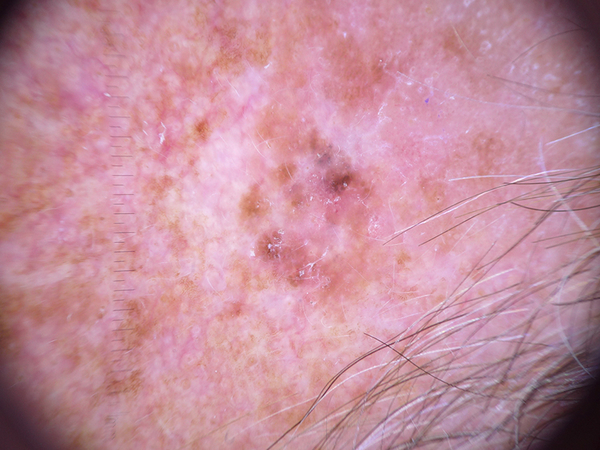

In [ ]:
Image.open('data/HAM10000_images_part_1/ISIC_0025661.jpg')

Now lets plot the counts of the differenct classes to classify.

In [ ]:
data['cell_type'].value_counts() 

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

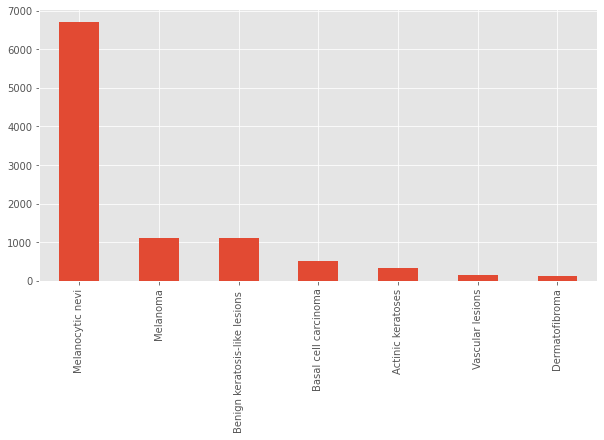

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

## Load Images

Images will be rescaled to (128,128,3) and standardized (division by 255)

In [ ]:
def load_img_data(size, df):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)
    
    return imgs, df['cell_type_idx'].values

In [ ]:
imgs, target = load_img_data(128, data)

100%|██████████| 10015/10015 [1:54:16<00:00,  1.46it/s]


(10015, 128, 128, 3)


## train-test-validation split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.25)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(7511, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

# Model

In [ ]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):

        self.trainX, self.trainY, self.valX, self.valY, self.testX, self.testY = data
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False
        self.hidden_layers = hidden_layers
        self.classes = classes

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None


    def download_network(self):
        '''
        Download the CNN 
        '''
        nn = None

        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn


    def run(self, augmentation=True):
        '''
        Fine-tune in 2 phases.

        Augmentation options could be both phases or phase 1 only.
        '''
        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase 1 - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint for saving best phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        if augmentation: 
            history = self.model.fit(
                self.train_generator,
                steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
                epochs=self.EPOCHS,
                validation_data=(self.valX, self.valY),
                validation_steps=numValidationSamples // self.BATCH_SIZE,
                callbacks=[checkpoint])
        else:
             history = self.model.fit(
                x_train, y_train,
                steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
                epochs=self.EPOCHS,
                validation_data=(self.valX, self.valY),
                validation_steps=numValidationSamples // self.BATCH_SIZE,
                callbacks=[checkpoint])
            
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)
        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()
        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

        print ("\nPhase 2  - Fine Tune all Layers \n")
        # Release the full original CNN in Phase 2
        self.nn.trainable = True
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint for saving best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # update Tuner predictions based on best phase 2 weights
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')


    def load_weights(self, name):
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)


    def build(self):
        '''
        Add Dense layer to topless base CNN (Transfer learning)
        '''
        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))       
        print (model.summary())

        return model


    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        return train_generator

    
    def predict(self):
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')


    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

## Implementation

In [ ]:
model = Tuner(data = train_val_test, 
              architecture = 'ResNet152V2', 
              hidden_layers = [512, 128], 
              classes = len(set(target)), 
              epochs = 10, 
              batch_size = 32)
model_2 = model

model.run()

In [ ]:
model_2.run(augmentation=False)

In [ ]:
model = _
model = Tuner(data = train_val_test, 
              architecture = 'DenseNet201', 
              hidden_layers = [512, 128], 
              classes = len(set(target)), 
              epochs = 10, 
              batch_size = 32)
model_2 = model

model.run()

In [ ]:
model_2.run(augmentation=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_3 (Flatten)         (None, 30720)             0         
                                                                 
 dropout_9 (Dropout)         (None, 30720)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               15729152  
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 1.6756 - accuracy: 0.5285
Epoch 1: val_loss improved from inf to 1.01794, saving model to DenseNet201_ph1_weights.hdf5
117/117 [==============================] - 632s 5s/step - loss: 1.6756 - accuracy: 0.5285 - val_loss: 1.0179 - val_accuracy: 0.7026
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 1.1036 - accuracy: 0.6812
Epoch 2: val_loss improved from 1.01794 to 0.83029, saving model to DenseNet201_ph1_weights.hdf5
117/117 [==============================] - 621s 5s/step - loss: 1.1036 - accuracy: 0.6812 - val_loss: 0.8303 - val_accuracy: 0.7485
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.7062
Epoch 3: val_loss improved from 0.83029 to 0.75800, saving model to DenseNet201_ph1_weights.hdf5
117/117 [==============================] - 620s 5s/step - loss: 0.9407 - accuracy: 0.7062 - val_loss: 0.7580 - val_accuracy: 0.7445
Epoch 4/10
117/117 [=========

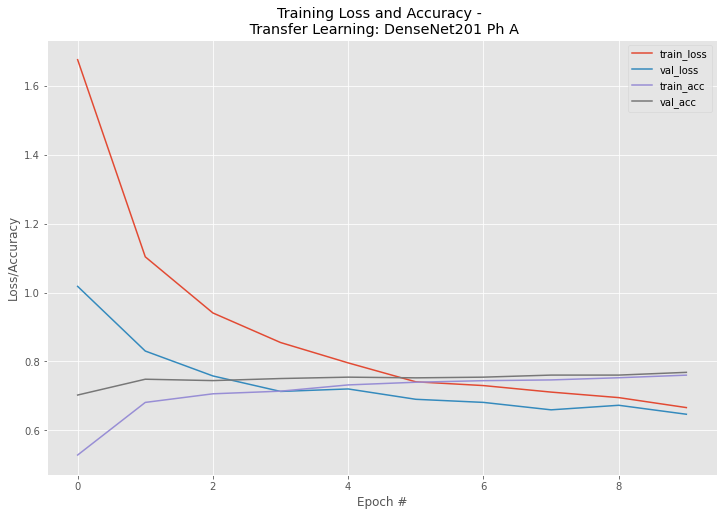


Phase B  - Fine Tune all Layers 



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6795 
Epoch 1: val_loss improved from inf to 0.84402, saving model to DenseNet201_ph2_weights.hdf5
117/117 [==============================] - 3190s 27s/step - loss: 0.9451 - accuracy: 0.6795 - val_loss: 0.8440 - val_accuracy: 0.7246
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.7224 
Epoch 2: val_loss improved from 0.84402 to 0.76606, saving model to DenseNet201_ph2_weights.hdf5
117/117 [==============================] - 3122s 27s/step - loss: 0.7913 - accuracy: 0.7224 - val_loss: 0.7661 - val_accuracy: 0.7265
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7445 
Epoch 3: val_loss improved from 0.76606 to 0.72701, saving model to DenseNet201_ph2_weights.hdf5
117/117 [==============================] - 3134s 27s/step - loss: 0.7109 - accuracy: 0.7445 - val_loss: 0.7270 - val_accuracy: 0.7505
Epoch 4/10
117/117 [

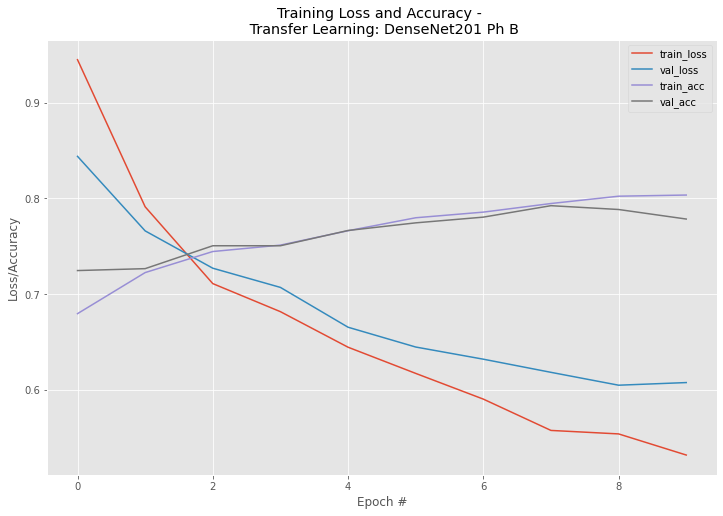

In [ ]:
model = Tuner(data = train_val_test, 
              architecture = 'DenseNet201', 
              hidden_layers = [512, 128], 
              classes = len(set(target)), 
              epochs = 10, 
              batch_size = 64)

model.run()

## Save the model

In [ ]:
model.model.save('tune_model') 
model.model.save('model.h5') 

In [ ]:
# possiblely load in the future

from keras.models import load_model
pretrained_model = load_model('model.h5')